<a href="https://colab.research.google.com/github/kuihua/NLP-Week1-Text-Classification/blob/main/sms_spam_detection_nlpProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

SMS Spam Detection using Transfer learning.

# Setup Python Libraries (pip)

In [ ]:
#install some Python packages with pip

%pip install numpy torch datasets transformers evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
# let's check the version we are using

%pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==4.0.0
evaluate==0.4.6
numpy==2.0.2
torch==2.9.0+cu126
torchao==0.10.0
torchaudio==2.9.0+cu126
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision==0.24.0+cu126
transformers==4.57.2


In [ ]:
pip install scikit-learn matplotlib

# Importing Libraries

In [ ]:
# load ds
from datasets import load_dataset
# tokenizer
from transformers import AutoTokenizer

In [ ]:
import numpy as np
# training metrics
import evaluate

In [ ]:
# training configs
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy
from transformers import DataCollatorWithPadding

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

In [ ]:
# to test examples
from transformers import pipeline
import torch

# Create SMS Dataset for Fine-tuning BERT

## Let's load the SMS Dataset

In [ ]:
# path to dataset
path =  "/content/drive/MyDrive/nlp_archive/dataset.csv"

In [ ]:
raw_dataset = load_dataset("csv", data_files=path)

Generating train split: 0 examples [00:00, ? examples/s]

## Let's create the train, validation, test sets

In [ ]:
# get train and validation set

dataset = raw_dataset['train'].train_test_split(test_size=0.2, seed=42, shuffle=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 8768
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 2193
    })
})

In [ ]:
dataset = raw_dataset['train'].train_test_split(test_size=0.2, seed=42, shuffle=True)

In [ ]:
# rename validation key to 'val'

dataset['val'] = dataset['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 8768
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 2193
    })
    val: Dataset({
        features: ['labels', 'text'],
        num_rows: 2193
    })
})

In [ ]:
# from datasets import DatasetDict

# # Split raw_dataset['train'] into a training set (80%) and a temporary set (20%)
# # The temporary set will then be further split into validation and test sets.
# train_temp_split = raw_dataset['train'].train_test_split(test_size=0.2, seed=42, shuffle=True)

# # Split the temporary set (20%) into validation (10%) and test (10%)
# # We take 50% of the temporary set for validation and 50% for test.
# val_test_split = train_temp_split['test'].train_test_split(test_size=0.5, seed=42, shuffle=True)

# # Assemble the final DatasetDict with distinct train, validation, and test sets
# dataset = DatasetDict({
#     'train': train_temp_split['train'],
#     'val': val_test_split['train'], # Renaming 'train' from val_test_split to 'val'
#     'test': val_test_split['test']
# })

# dataset

## We start by tokenizing our dataset with the BERT's Fast Tokenizer

In [ ]:
# let's import the pretrained faster tokenizer from huggingface
# source: (https://huggingface.co/distilbert-base-uncased)

In [ ]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
id2label = {0:'ham',1:'spam'}
label2id = {'ham':0,'spam':1}

# Convert string labels ('ham', 'spam') to integer labels (0, 1) using the label2id mapping.
def encode_labels(example):
    example['labels'] = label2id[example['labels']]
    return example

# process one label at a time
dataset = dataset.map(encode_labels, batched=False)

# tokenize the text in batches with truncation and padding based on BERT requirements
def tokenization(example):
    # Convert all elements in 'example["text"]' to strings, handling None or NaN values
    texts = [str(t) if t is not None and not (isinstance(t, float) and np.isnan(t)) else "" for t in example['text']]
    return tokenizer(texts, truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenization, batched=True, remove_columns=['text'])
tokenized_dataset

Map:   0%|          | 0/8768 [00:00<?, ? examples/s]

Map:   0%|          | 0/2193 [00:00<?, ? examples/s]

Map:   0%|          | 0/8768 [00:00<?, ? examples/s]

Map:   0%|          | 0/2193 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 8768
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2193
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2193
    })
})

# Setup Training Metrics (Accuracy, F1)

In [ ]:
# we setup the training to evaluate the accuracy and f1 scores
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1}

# Setup Training Configurations

In [ ]:
# get bert model with a sequence classification head for text classification
# source: (https://huggingface.co/distilbert-base-uncased)
checkpoint = 'distilbert-base-uncased'
num_labels = 2 # ham/spam

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# setup custom training arguments
# 1. store training checkpoints to 'results' output directory
# 2. fine-tune for just 1 epoch
# 3,4. use 16 as a batch size to speed things up
# 5. evaluate validation set every 500 steps (this is the default steps)
# 6. load the best model based on the lowest validation loss at the end of training

training_args = TrainingArguments(
    seed=42,
    output_dir = './results',
    num_train_epochs = 2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    eval_strategy = "epoch",
    save_strategy = 'epoch',
    # 0.00005 lr
    learning_rate = 0.00005,
    # turns off wandb
    report_to=None
)

# disable wandb logging (a v4 huggingface artifact)
os.environ['WANDB_DISABLED']= "true"

# Ensure dataset is in PyTorch format to pass labels to the model for loss computation
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# ensure labels are correctly passed
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors="pt")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Evaluate UnFine-Tuned BERT on Test Set for a Baseline Metric


In [ ]:
# # let's first evaluate unfine-tuned model with test set
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.6357584595680237,
 'eval_model_preparation_time': 0.0015,
 'eval_accuracy': 0.7829457364341085,
 'eval_f1': 0.0,
 'eval_runtime': 35.6655,
 'eval_samples_per_second': 61.488,
 'eval_steps_per_second': 3.869}

Without fine-tuning BERT, our model currently has around **78.3% Accuracy (eval_accuracy)** and **0% F1 (eval_f1)**, which is pretty bad.


Let's make it better with transfer learning!

# Fine-Tune BERT with SMS Dataset

First run.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.125200,0.065876,0.980392,0.954593
2,0.029800,0.075423,0.982216,0.958643


TrainOutput(global_step=1096, training_loss=0.07254778403435311, metrics={'train_runtime': 848.3524, 'train_samples_per_second': 20.671, 'train_steps_per_second': 1.292, 'total_flos': 2322948302831616.0, 'train_loss': 0.07254778403435311, 'epoch': 2.0})

In [ ]:
# let's see how well it did in the test set

trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.06587599962949753,
 'eval_accuracy': 0.9803921568627451,
 'eval_f1': 0.9545934530095037,
 'eval_runtime': 30.5937,
 'eval_samples_per_second': 71.681,
 'eval_steps_per_second': 4.511,
 'epoch': 2.0}

We got a **98.0% Accuracy (eval_accuracy)** and **95.4% F1 (eval_f1)** with 2 epochs!

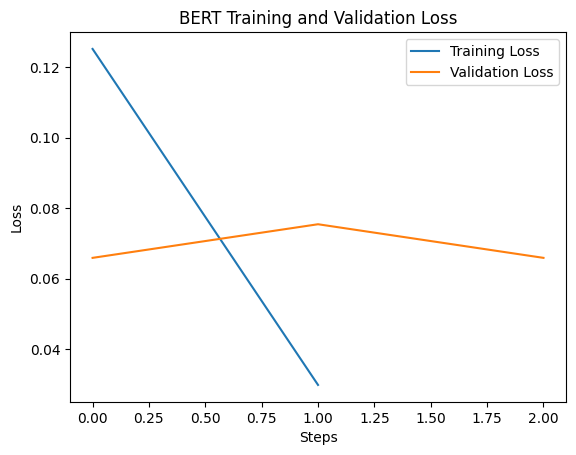

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get training loss from the log history
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
# Get validation loss from the log history
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

plt.figure()
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

plt.title('BERT Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# save to img
plt.savefig('training_and_validation_loss.png')
files.download('training_and_validation_loss.png')

# Display the plot
plt.show()

# Fine Tuning Hyperparameters

Second run with base model. Batch size and learning rate changed.

In [ ]:
checkpoint = 'distilbert-base-uncased'

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Changing hyperparameter(s)

training_args = TrainingArguments(
    seed=42,
    output_dir = './results',
    num_train_epochs = 2,
    # batch size 16 -> 32
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    eval_strategy = "epoch",
    save_strategy = 'epoch',
    # lr 0.00005 -> 0.0001, scale lr linearly
    learning_rate = 0.0001,
    # turns off wandb
    report_to=None
)

# disable wandb logging (a v4 huggingface artifact)
os.environ['WANDB_DISABLED']= "true"

# Ensure dataset is in PyTorch format to pass labels to the model for loss computation
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# ensure labels are correctly passed
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors="pt")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.088344,0.980392,0.954011
2,0.025700,0.081585,0.984040,0.963041


TrainOutput(global_step=548, training_loss=0.023536083417652297, metrics={'train_runtime': 828.6341, 'train_samples_per_second': 21.163, 'train_steps_per_second': 0.661, 'total_flos': 2322948302831616.0, 'train_loss': 0.023536083417652297, 'epoch': 2.0})

2 epochs

In [ ]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.0650782510638237,
 'eval_accuracy': 0.97765617875057,
 'eval_f1': 0.947481243301179,
 'eval_runtime': 30.8126,
 'eval_samples_per_second': 71.172,
 'eval_steps_per_second': 2.239,
 'epoch': 2.0}

2 epochs continued

In [ ]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.08158522099256516,
 'eval_accuracy': 0.9840401276789785,
 'eval_f1': 0.9630411826821542,
 'eval_runtime': 33.2021,
 'eval_samples_per_second': 66.05,
 'eval_steps_per_second': 2.078,
 'epoch': 2.0}

We got a 97.7% Accuracy (eval_accuracy) and 94.7% F1 (eval_f1) with 2 epochs!

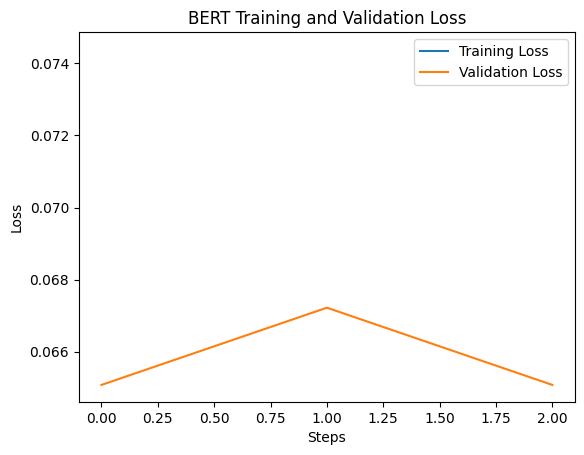

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get training loss from the log history for the second run
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
# Get validation loss from the log history
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

plt.figure()
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

plt.title('BERT Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# save to img
plt.savefig('training_and_validation_loss2.png')
files.download('training_and_validation_loss2.png')

# Display the plot
plt.show()

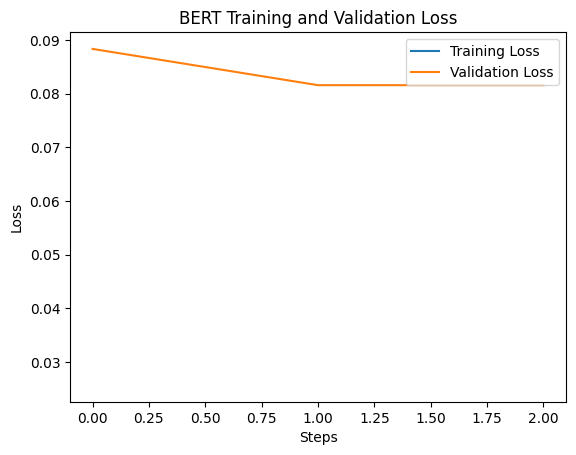

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get training loss from the log history for the second run
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
# Get validation loss from the log history
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

plt.figure()
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

plt.title('BERT Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# save to img
plt.savefig('training_and_validation_loss3.png')
files.download('training_and_validation_loss3.png')

# Display the plot
plt.show()

# Testing Data

In [ ]:
import pandas as pd

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sn

We added our own collected data to use as a test set. Using the spam_classifier we can see the actual vs the predicted.

In [ ]:
# get current device with pytorch
device = torch.cuda.current_device()

Device set to use cuda:0


In [ ]:
# importing
myPath = "/content/drive/MyDrive/nlp_archive/myData.csv"
myDataset = load_dataset("csv", data_files=myPath)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# see displayed text and prediction
df = pd.read_csv(myPath)

def checkActualvsPredicted(df):
  correct = 0
  total = 0

  # iterate through each row and print out the results, increment counter
  for index, row in df.iterrows():
      # get values from the spam classifier, the [0] accesses the returned dictionary
      prediction_output = spam_classifier(row['text'])[0]
      pred_label = prediction_output['label']
      confidence = prediction_output['score']
      # get actual label
      actual_label = row['labels']

      # print results
      print(f"{index+1}. Actual: {actual_label} | Predicted: {pred_label} (Score: {confidence:.4f})")

      if actual_label == pred_label:
          correct += 1
      else:
          # print text that was predicted wrongly
          print("Message: " + row['text'])
      total += 1

    # print total accuracy
    print(f"Accuracy for myDataset: {correct*100/total:.4f}%")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


1. Actual: spam | Predicted: spam
2. Actual: spam | Predicted: ham
3. Actual: spam | Predicted: spam
4. Actual: spam | Predicted: spam
5. Actual: spam | Predicted: spam
6. Actual: spam | Predicted: ham
7. Actual: spam | Predicted: ham
8. Actual: spam | Predicted: ham
9. Actual: spam | Predicted: spam
10. Actual: spam | Predicted: spam
11. Actual: spam | Predicted: spam
12. Actual: spam | Predicted: ham
13. Actual: spam | Predicted: spam
14. Actual: spam | Predicted: spam
15. Actual: spam | Predicted: spam
16. Actual: spam | Predicted: spam
17. Actual: spam | Predicted: spam
18. Actual: spam | Predicted: spam
19. Actual: spam | Predicted: spam
20. Actual: spam | Predicted: spam
21. Actual: spam | Predicted: spam
22. Actual: spam | Predicted: ham
23. Actual: spam | Predicted: ham
24. Actual: spam | Predicted: spam
25. Actual: spam | Predicted: spam
26. Actual: spam | Predicted: spam
27. Actual: spam | Predicted: spam
28. Actual: spam | Predicted: ham
29. Actual: spam | Predicted: spam
30

In [ ]:
# process one label at a time for test set
myDataset = myDataset.map(encode_labels, batched=False)

my_tokenized_dataset = myDataset.map(tokenization, batched=True, remove_columns=['text'])
my_tokenized_dataset

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 76
    })
})

### Testing with  model 1, checkpoint 1096

In [ ]:
# load model
checkpoint = '/content/drive/MyDrive/nlp_archive/results_run1/checkpoint-1096/'
model1 = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)
spam_classifier = pipeline(task='text-classification', model=model1, tokenizer=tokenizer,device=device)

In [ ]:
# get metrics from model for myDataset
training_args = TrainingArguments(
    seed=42,
    output_dir = './results',
    num_train_epochs = 2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    eval_strategy = "epoch",
    save_strategy = 'epoch',
    # 0.00005 lr
    learning_rate = 0.00005,
    # turns off wandb
    report_to=None
)

eval_trainer = Trainer(
    model=model1,
    args=training_args,
    eval_dataset=my_tokenized_dataset['train'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

eval_trainer.evaluate(my_tokenized_dataset['train'])

In [ ]:
checkActualvsPredicted(df)

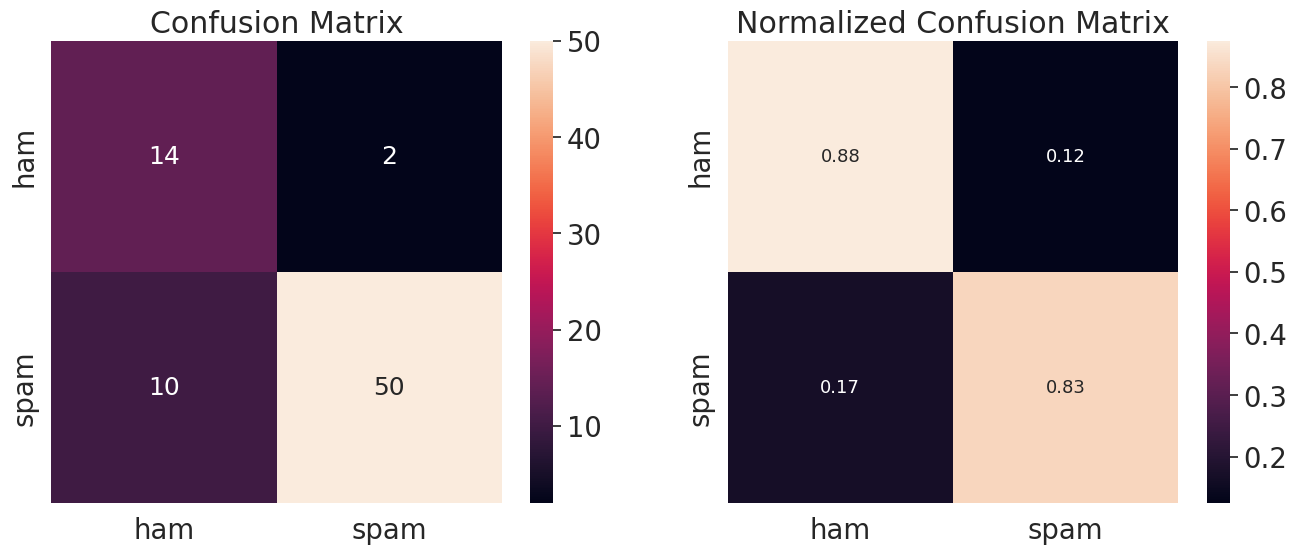

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
# create confusion matrices using test set
y_pred = []
y_truth = []

# add predicted label and actual label to list
for index, row, in df.iterrows():
    pred_label = spam_classifier(row['text'])[0]['label']
    y_pred.append(pred_label)
    y_truth.append(row['labels'])

# set labels for matrix axes
label_list =['ham','spam']
label_name = [label for label in label_list]

# create conf matrix and normalized version
conf_matrix = confusion_matrix(y_truth, y_pred, labels=label_list)
conf_matrix_normalized = confusion_matrix(y_truth, y_pred, labels=label_list, normalize='true')

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=label_name, columns=label_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_normalized, index=label_name, columns=label_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

# save to img
plt.savefig('test_confusion_matrix2.png')
files.download('test_confusion_matrix2.png')

# display matrix
plt.show()

In [ ]:
print(f'Test Set Accuracy score =  {100*accuracy_score(y_truth, y_pred):.3f}%')
print(f'Test Set Precision score =  {100*precision_score(y_truth, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_truth, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_truth, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  84.211%
Test Set Precision score =  77.244%
Test Set Recall score =  85.417%
Test Set F-score score =  79.6%


### Testing with model 2, checkpoint 548

In [ ]:
# load model 2
checkpoint = '/content/drive/MyDrive/nlp_archive/results_run2/checkpoint-548/'
model2 = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)
spam_classifier = pipeline(task='text-classification', model=model2, tokenizer=tokenizer,device=device)

In [ ]:
# get metrics from model for myDataset
training_args = TrainingArguments(
    seed=42,
    output_dir = './results',
    num_train_epochs = 2,
    # batch size 16 -> 32
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    eval_strategy = "epoch",
    save_strategy = 'epoch',
    # lr 0.00005 -> 0.0001, scale lr linearly
    learning_rate = 0.0001,
    # turns off wandb
    report_to=None
)

eval_trainer = Trainer(
    model=model2,
    args=training_args,
    eval_dataset=my_tokenized_dataset['train'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

eval_trainer.evaluate(my_tokenized_dataset['train'])

{'eval_train_loss': 1.0935298204421997,
 'eval_train_accuracy': 0.7763157894736842,
 'eval_train_f1': 0.8411214953271028,
 'eval_train_runtime': 0.3382,
 'eval_train_samples_per_second': 224.738,
 'eval_train_steps_per_second': 8.871,
 'epoch': 2.0}

In [ ]:
checkActualvsPredicted(df)

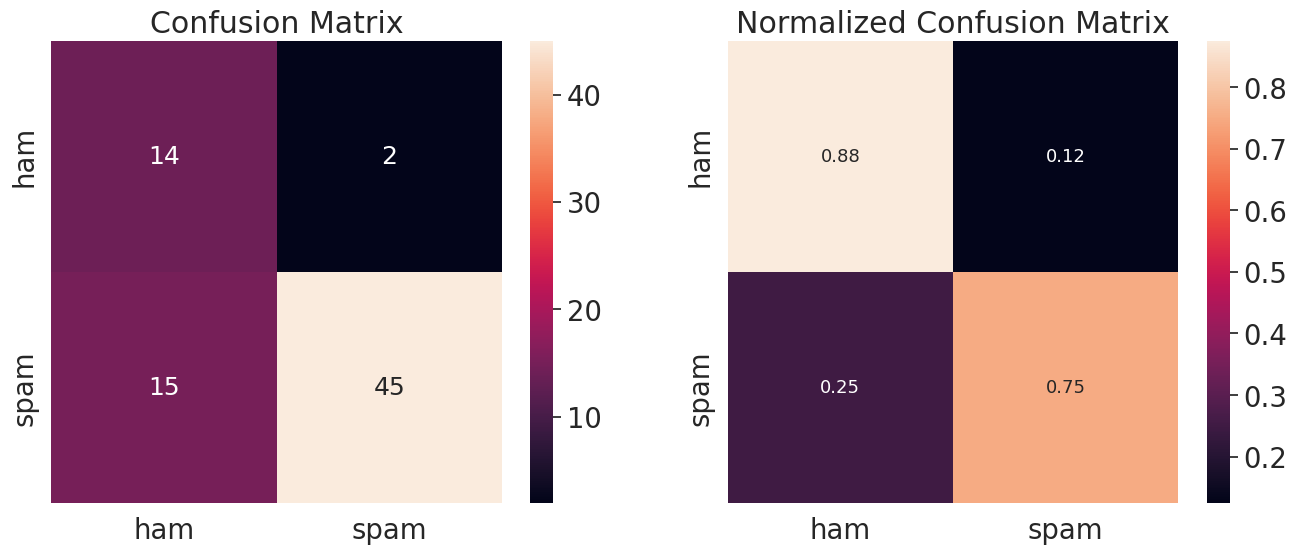

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
# create confusion matrices using test set
y_pred = []
y_truth = []

# add predicted label and actual label to list
for index, row, in df.iterrows():
    pred_label = spam_classifier(row['text'])[0]['label']
    y_pred.append(pred_label)
    y_truth.append(row['labels'])

# set labels for matrix axes
label_list =['ham','spam']
label_name = [label for label in label_list]

# create conf matrix and normalized version
conf_matrix = confusion_matrix(y_truth, y_pred, labels=label_list)
conf_matrix_normalized = confusion_matrix(y_truth, y_pred, labels=label_list, normalize='true')

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=label_name, columns=label_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_normalized, index=label_name, columns=label_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

# save to img
plt.savefig('test_confusion_matrix.png')
files.download('test_confusion_matrix.png')

# display matrix
plt.show()

In [ ]:
# Test set metrics
print(f'Test Set Accuracy score =  {100*accuracy_score(y_truth, y_pred):.3f}%')
print(f'Test Set Precision score =  {100*precision_score(y_truth, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_truth, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_truth, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  77.632%
Test Set Precision score =  72.010%
Test Set Recall score =  81.250%
Test Set F-score score =  73.2%
